# reusing the transfer learning re-trained model on new data, back on the same data


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import torch
import glob
import os
import pickle
from bs4 import BeautifulSoup
# data_path = '/Users/ruchiraravishankar/Downloads/iam_dataset/'
data_path = '/content/drive/MyDrive/iam_dataset/'
save_path = "/content/drive/MyDrive/iam_dataset/saved_model/"

In [3]:
# toggles to change training and nodes

# set model_node to 2,3,4,5,6,7, or 23 for nodes 2 and 3 trained model
model_node = 2

fc_pi = 'fc' 

# # transfer learning toggle
# fc = True
# conv = False
# plain_inf = False

# toggle to save model
save_model = False
# toggle to save results
save_results = True

In [4]:
labelled_data = np.load(data_path + "labelled_data.npy")

In [5]:
labelled_data_0 = labelled_data[labelled_data[:,1] == '000']

print(labelled_data_0.shape)

labelled_data_0 = labelled_data_0[:196] # original set of data to the one that its originally trained on
print(labelled_data_0.shape)

print(np.unique(labelled_data_0[:,1]))

(693, 2)
(196, 2)
['000']


In [6]:
remove_000 = labelled_data[labelled_data[:,1]!='000']

print(np.unique(remove_000[:,1]))
print(np.unique(remove_000[:,1]).shape)

['085' '118' '150' '151' '152' '153' '154' '155' '202' '203' '204' '205'
 '206' '207' '208' '209' '247' '248' '273' '274' '315' '332' '333' '334'
 '335' '336' '337' '338' '339' '340' '341' '342' '343' '344' '345' '346'
 '347' '348' '349' '384' '415' '551' '552' '567' '588' '634' '635' '670'
 '671']
(49,)


In [7]:
y = [remove_000[remove_000[:,1]==k] for k in np.unique(remove_000[:,1])]
print(len(y))

49


In [8]:
labelled_data_1 = []
for i in y:
    labelled_data_1.append(i[:4]) # original set of data to the one that its originally trained on
print(len(labelled_data_1))

labelled_data_1 = np.array(labelled_data_1)

print(labelled_data_1.shape)

49
(49, 4, 2)


In [9]:
labelled_data_1=labelled_data_1.reshape(-1,2)

In [10]:
print(labelled_data_1.shape)

(196, 2)


In [11]:
print(np.unique(labelled_data_1[:,1]))

['085' '118' '150' '151' '152' '153' '154' '155' '202' '203' '204' '205'
 '206' '207' '208' '209' '247' '248' '273' '274' '315' '332' '333' '334'
 '335' '336' '337' '338' '339' '340' '341' '342' '343' '344' '345' '346'
 '347' '348' '349' '384' '415' '551' '552' '567' '588' '634' '635' '670'
 '671']


In [12]:
labelled_data_new = np.concatenate((labelled_data_0, labelled_data_1))
np.random.shuffle(labelled_data_new)
print(labelled_data_new.shape) # mix of sentences from writer id 0 and others, labelled

(392, 2)


In [13]:
# split before augmenting to ensure the sentences are being split and not the augmented samples
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(labelled_data_new[:,0], labelled_data_new[:,1], test_size=0.33, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(262,) (130,) (262,) (130,)


In [14]:
from sklearn.utils import shuffle
from PIL import Image
import random

CROP_SIZE = 113
NUM_LABELS = 50

def get_augmented_sample(sample, label, sample_ratio):
    # Get current image details
    img = Image.open(sample)
    img_width = img.size[0]
    img_height = img.size[1]

    # Compute resize dimensions such that aspect ratio is maintained
    height_fac = CROP_SIZE / img_height
    size = (int(img_width * height_fac), CROP_SIZE)

    # Resize image 
    new_img = img.resize((size), Image.ANTIALIAS)
    new_img_width = new_img.size[0]
    new_img_height = new_img.size[1]

    # Generate a random number of crops of size 113x113 from the resized image
    x_coord = list(range(0, new_img_width - CROP_SIZE))
    num_crops = int(len(x_coord) * sample_ratio)
    random_x_coord = random.sample(x_coord, num_crops)
    
    # Create augmented images (cropped forms) and map them to a label (writer)
    images = []
    labels = []
    for x in random_x_coord:
        img_crop = new_img.crop((x, 0, x + CROP_SIZE, CROP_SIZE))
        # Transform image to an array of numbers
        images.append(np.asarray(img_crop))
        labels.append(label)

    return images, labels

In [15]:
def augment(data, labels):
    augmented_sample_list = []
    augmented_label_list = []
    for i in range(len(data)):
        augmented_samples, augmented_labels = get_augmented_sample(data[i], labels[i],0.1)
        augmented_sample_list.append(augmented_samples)
        augmented_label_list.append(augmented_labels)
    return augmented_sample_list, augmented_label_list

In [16]:
augsamps, auglbls = augment(X_train, y_train) # returns two lists of arrays
ausamps_test, auglbls_test = augment(X_test, y_test)

In [17]:
import operator
from functools import reduce

# flattening the lists
aug_samps = reduce(operator.add, augsamps)
aug_lbls = reduce(operator.add, auglbls)

aug_samps_test = reduce(operator.add, ausamps_test)
aug_lbls_test = reduce(operator.add, auglbls_test)
print(len(aug_samps))
print(len(aug_lbls))

print(len(aug_samps_test))
print(len(aug_lbls_test))

43983
43983
24253
24253


In [18]:
# converting lists to arrays
aug_samps_arr = np.array(aug_samps)
aug_lbls_arr = np.array(aug_lbls)
aug_samps_arr_test = np.array(aug_samps_test)
aug_lbls_arr_test = np.array(aug_lbls_test)

print(aug_samps_arr.shape)
print(aug_lbls_arr.shape)
print(aug_samps_arr_test.shape)
print(aug_lbls_arr_test.shape)

(43983, 113, 113)
(43983,)
(24253, 113, 113)
(24253,)


In [19]:
X_train = aug_samps_arr
X_train = X_train.reshape(X_train.shape[0], 1, CROP_SIZE, CROP_SIZE)
X_train = X_train.astype('float16')
# X_data /= 255
X_train /= 255.0
y_train = aug_lbls_arr


X_test = aug_samps_arr_test
X_test = X_test.reshape(X_test.shape[0], 1, CROP_SIZE, CROP_SIZE)
X_test = X_test.astype('float16')
X_test /= 255.0
y_test = aug_lbls_arr_test


In [20]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(43983, 1, 113, 113)
(43983,)
(24253, 1, 113, 113)
(24253,)


In [21]:
new = np.unique(y_train)
print(new)

y_train[y_train !='000'] = 1
new = np.unique(y_train)
print(new)

y_train[y_train=='000'] = 0
new = np.unique(y_train)
print(new)

print(y_train.shape)

y_train = y_train.astype('float16')

print(np.unique(y_train))

['000' '085' '118' '150' '151' '152' '153' '154' '155' '202' '203' '204'
 '205' '206' '207' '208' '209' '247' '248' '273' '274' '315' '332' '333'
 '334' '335' '336' '337' '338' '339' '340' '341' '342' '343' '344' '345'
 '346' '347' '348' '349' '384' '415' '551' '567' '588' '634' '635' '670'
 '671']
['000' '1']
['0' '1']
(43983,)
[0. 1.]


In [22]:
new = np.unique(y_test)
print(new)

y_test[y_test !='000'] = 1
new = np.unique(y_test)
print(new)

y_test[y_test=='000'] = 0
new = np.unique(y_test)
print(new)

print(y_test.shape)

y_test = y_test.astype('float16')

print(np.unique(y_test))

['000' '118' '150' '151' '153' '154' '155' '202' '204' '205' '206' '207'
 '208' '209' '247' '248' '274' '315' '332' '333' '334' '335' '337' '338'
 '339' '340' '341' '342' '343' '346' '348' '349' '384' '415' '552' '567'
 '634' '635' '670']
['000' '1']
['0' '1']
(24253,)
[0. 1.]


In [23]:
torch.manual_seed(42)
CUDA = torch.cuda.is_available()

device = torch.device('cuda' if CUDA else 'cpu')
kwargs = {'num_workers': 1, 'pin_memory': True} if CUDA else {}
device

device(type='cuda')

In [24]:
from torch.utils.data import TensorDataset, DataLoader

if CUDA:
  tensor_x_train = torch.Tensor(X_train).type(torch.cuda.FloatTensor) # transform to torch tensor
  tensor_y_train = torch.Tensor(y_train).type(torch.cuda.FloatTensor).long()
else:
  tensor_x_train = torch.Tensor(X_train).type(torch.FloatTensor) # transform to torch tensor
  tensor_y_train = torch.Tensor(y_train).type(torch.FloatTensor).long()

train_dataset = TensorDataset(tensor_x_train,tensor_y_train) # create your dataset
train_dataloader = DataLoader(train_dataset,batch_size=16, shuffle=True, drop_last=True) # create your dataloader

In [25]:
if CUDA:
  tensor_x_test = torch.Tensor(X_test).type(torch.cuda.FloatTensor) # transform to torch tensor
  tensor_y_test = torch.Tensor(y_test).type(torch.cuda.FloatTensor).long()
else:
  tensor_x_test = torch.Tensor(X_test).type(torch.FloatTensor) # transform to torch tensor
  tensor_y_test = torch.Tensor(y_test).type(torch.FloatTensor).long()

test_dataset = TensorDataset(tensor_x_test,tensor_y_test) # create your datset
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True) # create your dataloader

In [26]:
tensor_x_train.shape

torch.Size([43983, 1, 113, 113])

In [27]:
from torch import nn
class Binary_Classifier(nn.Module): 
    def __init__(self):
        super(Binary_Classifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.conv_drop = nn.Dropout2d()
        self.conv3 = nn.Conv2d(20, 30, kernel_size=3)
        self.fc1 = nn.Linear(4320, 1024)
        self.fc2 = nn.Linear(1024, 2)
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(2)
    def forward(self, x):
        x = self.relu(self.max_pool2d(self.conv1(x)))
        x = self.relu(self.max_pool2d(self.conv_drop(self.conv2(x))))
        x = self.relu(self.max_pool2d(self.conv_drop(self.conv3(x))))
        x = x.view(x.shape[0],-1)
        # print(x.shape)
        x = self.relu(self.fc1(x))
        x = self.conv_drop(x)
        x = self.fc2(x)
        return x

In [28]:
model=Binary_Classifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

In [29]:
model_node_2_fc = 'model_tf_3_convs_retrain_last_fc_node2.pt'
model_node_2_conv = 'model_tf_3_convs_retrain_last_conv_node2.pt'

model_node_3_fc = 'model_tf_3_convs_retrain_last_fc_node3.pt'
model_node_3_conv = 'model_tf_3_convs_retrain_last_conv_node3.pt'

model_node_4_fc = 'model_3_convs_node_4_fc.pt'
model_node_4_conv = 'model_3_convs_node_4_conv.pt'

model_node_5_fc = 'model_3_convs_node5_fc.pt'
model_node_5_conv = 'model_3_convs_node5_conv.pt'

model_node_6_fc = '3convs_node6_fc.pt'
model_node_6_conv = '3convs_node6_conv.pt'

model_node_7_fc = '3convs_node7_fc.pt'
model_node_7_conv = '3convs_node7_conv.pt'

model_node2_node3 = 'modelreuse_node2convmodel_retrainedfc_on_node3.pt'

In [30]:
if model_node == 2:
  model_path = model_node_2_conv


elif model_node == 3:
  model_path = model_node_3_conv


elif model_node == 4:
  model_path = model_node_4_conv


elif model_node == 5:
  model_path = model_node_5_conv


elif model_node == 6:
  model_path = model_node_6_conv

elif model_node == 7:
  model_path = model_node_7_conv


elif model_node == 23:
  model_path = model_node2_node3

else:
  print("set model_node variable at the top of the file")

In [31]:
# if os.path.exists(save_path+'/model_3_convs_node6_conv.pt'):
try:
    print('Loading checkpoint: %s' % save_path + model_path)
    path = torch.load(save_path + model_path)
    # epoch = path['epoch']
    model.load_state_dict(path['model'])
    optimizer.load_state_dict(path['optimizer'])
except Exception as e:
  print("nothing happened")
  print(e)

Loading checkpoint: /content/drive/MyDrive/testing_proj/iam_dataset/saved_model/model_tf_3_convs_retrain_last_conv_node2.pt


In [32]:
print(model.parameters)

<bound method Module.parameters of Binary_Classifier(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv_drop): Dropout2d(p=0.5, inplace=False)
  (conv3): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=4320, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
  (relu): ReLU()
  (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)>


In [33]:
print(device)

cuda


In [34]:
if fc_pi == 'fc':
  for param in model.parameters():
    param.requires_grad = False

In [35]:
if fc_pi == 'fc':
  num_ftrs = model.fc2.in_features
  print(num_ftrs)
  model.fc2 = nn.Linear(num_ftrs, 2).to(device)

1024


In [36]:
train_losses = []
train_loss_record = []

In [37]:
from datetime import datetime
train_log_string = '%s :: Epoch %i :: Iter %i / %i :: train loss: %0.4f'
def train(epoch):
    print('Start Epoch {} Training...'.format(epoch))
    model.train()
    train_loss = []
    train_loss_sum = []
    for idx, (data, target) in enumerate(train_dataloader):
        optimizer.zero_grad()
        #  forward-pass
        output = model(data)
        loss = criterion(output, target)
        #backward-pass
        loss.backward()
        # Update the parameters
        optimizer.step()
        train_loss.append(loss.data.cpu().numpy())
        train_loss_sum.append(loss)
        if ((idx +1) % 5000) == 0:
          print(train_log_string % (datetime.now(), epoch, idx + 1, len(train_dataloader), np.mean(train_loss)))
          train_loss = []
    mean_tr = torch.mean(torch.stack(train_loss_sum))
    print('Train Loss at epoch {}: {}\n'.format(epoch, mean_tr))
    train_loss_record.append(mean_tr)
    return train_loss_record

In [38]:
if fc_pi == 'fc':
  for epoch in range(15):
    tlr = train(epoch)

Start Epoch 0 Training...
Train Loss at epoch 0: 1.176456093788147

Start Epoch 1 Training...
Train Loss at epoch 1: 1.1792010068893433

Start Epoch 2 Training...
Train Loss at epoch 2: 1.1779117584228516

Start Epoch 3 Training...
Train Loss at epoch 3: 1.1766338348388672

Start Epoch 4 Training...
Train Loss at epoch 4: 1.1752318143844604

Start Epoch 5 Training...
Train Loss at epoch 5: 1.17824387550354

Start Epoch 6 Training...
Train Loss at epoch 6: 1.1744695901870728

Start Epoch 7 Training...
Train Loss at epoch 7: 1.1764589548110962

Start Epoch 8 Training...
Train Loss at epoch 8: 1.1767868995666504

Start Epoch 9 Training...
Train Loss at epoch 9: 1.1828066110610962

Start Epoch 10 Training...
Train Loss at epoch 10: 1.172984004020691

Start Epoch 11 Training...
Train Loss at epoch 11: 1.1771773099899292

Start Epoch 12 Training...
Train Loss at epoch 12: 1.1787424087524414

Start Epoch 13 Training...
Train Loss at epoch 13: 1.1761800050735474

Start Epoch 14 Training...
Tra

(15,)


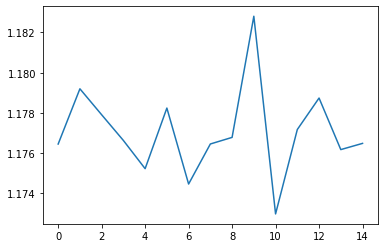

In [40]:
import matplotlib.pyplot as plt
if fc_pi == 'fc':
  temp = [t.detach().cpu().numpy() for t in tlr]
  arr = np.array(temp)
  print(arr.shape)

  plt.plot(arr)

In [41]:
result = []
prediction = []
model.eval()
with torch.no_grad():
    for idx, (data, target) in enumerate(test_dataloader):
        output = model(data)
        output_sm = nn.Softmax(dim=1)(output)
        _, predicted = torch.max(output, 1)
        prediction.append(predicted)
        result.append(output_sm)
        
result = torch.stack(result).detach().cpu().numpy()
prediction = torch.stack(prediction).detach().cpu().numpy()

print(result.shape, prediction.shape)

(1515, 16, 2) (1515, 16)


In [42]:
print(prediction.reshape(-1).shape)

(24240,)


In [43]:
import pandas as pd
res = pd.DataFrame(result.reshape(-1,2))
pred = pd.DataFrame(prediction.reshape(-1))

# res.to_csv("/content/drive/MyDrive/iam_dataset/saved_model/results_tf_reuse_original_data_conv.csv", header=False, index=False)
# pred.to_csv("/content/drive/MyDrive/iam_dataset/saved_model/pred_tf_reuse_original_data_conv.csv", header=False, index=False)

In [44]:
print(res.shape, pred.shape)

(24240, 2) (24240, 1)


In [45]:
y_test_new = y_test[:result.reshape(-1,2).shape[0]]

In [46]:
print(y_test_new.shape)

(24240,)


In [47]:
result_df = pd.DataFrame({'ground truth': y_test_new, 'NN output': prediction.reshape(-1), 'probs 0': res[0], 'probs 1': res[1]})
result_df

,ground truth,NN output,probs 0,probs 1
0,0.0,1,0.209575,0.790425
1,0.0,1,0.206334,0.793666
2,0.0,1,0.222185,0.777815
3,0.0,1,0.230955,0.769045
4,0.0,1,0.195560,0.804440
...,...,...,...,...
24235,0.0,1,0.217000,0.783000
24236,0.0,1,0.160074,0.839926
24237,0.0,1,0.205946,0.794054
24238,0.0,1,0.210555,0.789445


In [48]:
# work out the accuracy and other metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
actual = result_df['ground truth']
predicted = result_df['NN output']
# confusion matrix
matrix = confusion_matrix(actual, predicted, labels=[0,1])
print('Confusion matrix : \n',matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(actual, predicted, labels=[0,1]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

# classification report for precision, recall f1-score and accuracy
matrix_2 = classification_report(actual,predicted,labels=[0,1])
print('Classification report : \n',matrix_2)

Confusion matrix : 
 [[    0 16115]
 [    0  8125]]
Outcome values : 
 0 16115 0 8125
Classification report : 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     16115
           1       0.34      1.00      0.50      8125

    accuracy                           0.34     24240
   macro avg       0.17      0.50      0.25     24240
weighted avg       0.11      0.34      0.17     24240



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


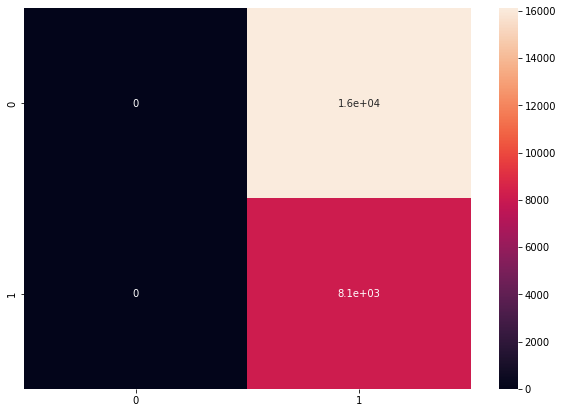

In [49]:
import matplotlib.pyplot as plt
import seaborn as sn
df_cm = pd.DataFrame(matrix, index = [i for i in "01"],
                  columns = [i for i in "01"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [50]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
matrix_3 = classification_report(actual,predicted,labels=[0,1], output_dict=True)
print('Classification report : \n',matrix_3)
accuracy_score(actual, predicted)

Classification report : 
 {'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 16115}, '1': {'precision': 0.3351897689768977, 'recall': 1.0, 'f1-score': 0.5020855862814769, 'support': 8125}, 'accuracy': 0.3351897689768977, 'macro avg': {'precision': 0.16759488448844884, 'recall': 0.5, 'f1-score': 0.25104279314073846, 'support': 24240}, 'weighted avg': {'precision': 0.11235218122678604, 'recall': 0.3351897689768977, 'f1-score': 0.16829395167231848, 'support': 24240}}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.3351897689768977

In [51]:
matrix_df = pd.DataFrame(matrix).transpose()
matrix_3_df = pd.DataFrame(matrix_3).transpose()
# matrix_df.to_csv("/content/drive/MyDrive/iam_dataset/saved_model/conf_matrix_transf_learn_conv_newdata_2.csv", header=False, index=False)

if save_results:
  if model_node == 2:
    if fc_pi == 'fc':
      matrix_3_df.to_csv(save_path + "classification_report_transf_learn_reuse_node2_conv_fc_retrain.csv", header=True, index=True)

    elif fc_pi == 'pi':
      matrix_3_df.to_csv(save_path + "classification_report_transf_learn_reuse_node2_conv_pi.csv", header=True, index=True)

    else:
      print("set model_node or fc_pi")
    
  elif model_node == 3:
    if fc_pi == 'fc':
      matrix_3_df.to_csv(save_path + "classification_report_transf_learn_reuse_node3_conv_fc_retrain.csv", header=True, index=True)

    elif fc_pi == 'pi':
      matrix_3_df.to_csv(save_path + "classification_report_transf_learn_reuse_node3_conv_pi.csv", header=True, index=True)

    else:
      print("set model_node or fc_pi")

  elif model_node == 4:
    if fc_pi == 'fc':
      matrix_3_df.to_csv(save_path + "classification_report_modelreuse_node4conv_retrainfc_on_node1.csv", header=True, index=True)

    elif fc_pi == 'pi':
      matrix_3_df.to_csv(save_path + "classification_report_modelreuse_node4conv_pi_on_node1.csv", header=True, index=True)

    else:
      print("set model_node or fc_pi")
  
  elif model_node == 5:
    if fc_pi == 'fc':
      matrix_3_df.to_csv(save_path + "classification_report_modelreuse_node5conv_retrainfc_on_node1.csv", header=True, index=True)

    elif fc_pi == 'pi':
      matrix_3_df.to_csv(save_path + "classification_report_modelreuse_node5conv_pi_on_node1.csv", header=True, index=True)

    else:
      print("set model_node or fc_pi")
  
  elif model_node == 6:
    if fc_pi == 'fc':
      matrix_3_df.to_csv(save_path + "classification_report_modelreuse_node6conv_retrainfc_on_node1.csv", header=True, index=True)

    elif fc_pi == 'pi':
      matrix_3_df.to_csv(save_path + "classification_report_modelreuse_node6conv_pi_on_node1.csv", header=True, index=True)

    else:
      print("set model_node or fc_pi")
  
  elif model_node == 7:
    if fc_pi == 'fc':
      matrix_3_df.to_csv(save_path + "classification_report_modelreuse_node7conv_retrainfc_on_node1.csv", header=True, index=True)

    elif fc_pi == 'pi':
      matrix_3_df.to_csv(save_path + "classification_report_modelreuse_node7conv_pi_on_node1.csv", header=True, index=True)

    else:
      print("set model_node or fc_pi")  

  elif model_node == 23:
      matrix_3_df.to_csv(save_path + "classification_report_modelreuse_node2and3model_on_node1.csv", header=True, index=True)
else:
    print("set model_node")

# pd.to_csv("/content/drive/MyDrive/iam_dataset/saved_model/classification_report.txt",matrix)
